**Настраиваю тетрадку для работы**

In [117]:
# Импортирую sklearn чтобы перед установкой ядра  была свежая версия библиотеки
#!pip install scikit-learn==1.3.1 -q
import sklearn
# Устанавливаю библиотеки, которых нет
# Устанавливаю ядро 3.7 для корректной работы библиотеки ydata_profiling
#!python -m ipykernel install --user --name py37env --display-name "Python 3.7"
# Устанавливаю версию matplotlib==3.7.3 для корректной работы библиотеки ydata_profiling
#!pip install matplotlib==3.7.3 -q
%matplotlib inline
# Устанавливию библиотеку ydata_profiling
# try:
#     import ydata_profiling
# except ModuleNotFoundError:
#     !pip install ydata_profiling -q
!pip install --upgrade ydata_profiling visions numba -q
# Импортиую нужные для работы библиотеки
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nltk.stem import SnowballStemmer
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error, 
    r2_score,
    mean_absolute_error,
)
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    StratifiedKFold,  
    KFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MultiLabelBinarizer
)
import time
from ydata_profiling import ProfileReport, compare
from ydata_profiling.config import Settings
# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)

In [118]:
# Устанавливаю формат отображения для чисел в DataFrame
pd.set_option('display.float_format', '{:,.2f}'.format)
# Устанавливаю тему по умолчанию для диаграмм Seaborn
sns.set_theme(style="ticks")
RANDOM_STATE = 42  

# Разработка модели машинного обучения для предсказания судьбы стартапов

В этом проекте я должен разработать модель машинного обучения, которая поможет определить судьбу стартапа. 



Для достижения этой цели мне предстоит проанализировать псевдо-реальные (реальные данные в которые добавлена синтетическая составляющая) даннын о стартапах, функционировавших в период с 1970 по 2018 годы, построить прогнозную модель для прогоза их закрытия.



Данные о стартапах находятся в файлах: 

- `kaggle_startups_test_28062024.csv`

- `kaggle_startups_train_28062024.csv`

<br><br>



В датасетах содержатся следующие признаки:

- `name` - Название стартапа

- `category_list` - Список категорий, к которым относится стартап

- `funding_total_usd` - Общая сумма финансирования в USD

- `status` - Статус стартапа (закрыт или действующий)

- `country_code` - Код страны

- `state_code` - Код штата

- `region` - Регион

- `city` - Город

- `funding_rounds` - Количество раундов финансирования

- `founded_at` - Дата основания

- `first_funding_at` - Дата первого раунда финансирования

- `last_funding_at` - Дата последнего раунда финансирования

- `closed_at` - Дата закрытия стартапа (если применимо)

- `lifetime` - Время существования стартапа в днях

- `status` - Целевой признак. Для каждого стартапа необходимо предсказать категориальное значение соответствующее прогнозу `operating`, `closed`.

<br><br>



Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

- Бюджет на разработку скважин в регионе — 10 млрд рублей.

- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

### Загрузка данных

In [119]:
startups_test = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-39-ds/kaggle_startups_test_28062024.csv')
startups_train = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-39-ds/kaggle_startups_train_28062024.csv')

In [120]:
startups_test.sample(1)

name   category_list  funding_total_usd country_code  \
469  Boom Financial  Finance|Mobile      50,729,469.00          USA   

    state_code       region       city  funding_rounds first_funding_at  \
469         CA  SF Bay Area  Palo Alto               6       2008-07-01   

    last_funding_at  lifetime  
469      2012-07-18      3653

In [121]:
startups_train.sample(1)

name        category_list  funding_total_usd     status  \
22829  Clinical Ink  Health and Wellness      24,300,000.00  operating   

      country_code state_code         region           city  funding_rounds  \
22829          USA         NC  Winston-Salem  Winston Salem               2   

       founded_at first_funding_at last_funding_at closed_at  
22829  2006-01-01       2013-10-16      2015-03-18       NaN

**Вывод по шагу 1.1:**

1. Загружены массивы - `startups_test`,  `startups_train`.

### Предобработка данных

#### Вывожу общую информацию о массивах

In [122]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [123]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


#### Задаю правильные типы столбцов

##### Устанавливаю тип дата

In [124]:
# Список названий колонок с датой
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
# Функция для смены типа на дату
def column_to_date(df):
    for column in date_columns:
        if column in df.columns:
            df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

In [125]:
# Меняю тип на дату в теренировочной выборке
column_to_date(startups_train)
# Проверка
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [126]:
# Меняю тип на дату в тестовой выборке
column_to_date(startups_test)
# Проверка
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


Все ок

#### Очистка и приведение к единому виду текстовых значений

In [127]:
# Функция для очистки текста
def clean_text(text):
    if isinstance(text, str):  # Проверка, что это строка
        # Убираем лишние пробелы, приводим к нижнему регистру и удаляем пробелы в начале/конце
        return ' '.join(text.split()).strip().lower()
    return text  # Возвращаем как есть, если это не строка (например, NaN)

In [128]:
# Список текстовых столбцов
text_columns = ['name', 'category_list', 'status', 'country_code', 'state_code', 'region', 'city']
# Функция для для очистки текстовых значений во всех текстовых колонках массива
def df_text_clean(df):
    for column in text_columns:
        if column in df.columns:
            # Применим очистку к каждому элементу в текстовых столбцах
            df[column] = df[column].fillna("unknown").apply(clean_text)

In [129]:
df_text_clean(startups_train)
startups_train.sample(3)

name                                  category_list  \
6200      avdirect  audio|e-commerce|online rental|startups|video   
44437        eegeo                       apps|software|technology   
21760  hyper games                                        unknown   

       funding_total_usd     status country_code state_code     region  \
6200                 NaN  operating          nld          7  amsterdam   
44437       4,300,000.00  operating          gbr         u3     dundee   
21760          94,244.79     closed          nor         12       oslo   

            city  funding_rounds founded_at first_funding_at last_funding_at  \
6200   amsterdam               1 2010-01-01       2010-01-01      2010-01-01   
44437     dundee               1 2011-12-02       2012-07-17      2012-07-17   
21760       oslo               1 2014-05-29       2015-11-03      2015-11-03   

       closed_at  
6200         NaT  
44437        NaT  
21760 2017-07-17

In [130]:
df_text_clean(startups_test)
startups_test.sample(3)

name  \
10912               ajubeo   
8464   blades.com (blades)   
13102          buildingeye   

                                                           category_list  \
10912                             cloud infrastructure|service providers   
8464                                                             unknown   
13102  big data|construction|governments|internet|real estate|technology   

       funding_total_usd country_code state_code   region     city  \
10912                NaN          usa         co   denver  boulder   
8464                 NaN      unknown    unknown  unknown  unknown   
13102                NaN      unknown    unknown  unknown  unknown   

       funding_rounds first_funding_at last_funding_at  lifetime  
10912               1       2013-08-21      2013-08-21      2557  
8464                1       2015-03-01      2015-03-01      9760  
13102               1       2012-02-01      2012-02-01      2192

#### Укрупнение категорий стартапов

In [219]:
def cat_consolidation(original_df, category_mapping):
    # Шаг 0: Создаем копию исходного массива
    df = original_df.copy()    
    
    # Преобразуем его в словарь, где ключом является 'Initial', а значением — 'Final'
    mapping = {row['Initial']: row['Final'] for _, row in category_mapping.iterrows()}
    
    # Шаг 2: Разделить категории по символу |, обработав пропуски
    df['categories_split'] = df['category_list'].fillna('unknown').str.lower().str.split('|')  # Приводим к нижнему регистру
    
    # Шаг 3: Удалить дубликаты категорий для каждого стартапа и применить маппинг
    df['mapped_categories'] = df['categories_split'].apply(
        lambda categories: list(set([mapping.get(cat.strip(), cat) for cat in categories])) if isinstance(categories, list) else []
    )
    
    # Шаг 4: Создать бинарные признаки для категорий
    mlb = MultiLabelBinarizer()
    binary_categories = pd.DataFrame(mlb.fit_transform(df['mapped_categories']), columns=mlb.classes_, index=df.index)
    
    # Шаг 5: Проверяем наличие дубликатов колонок и избегаем их
    columns_to_add = [col for col in binary_categories.columns if col not in df.columns]
    
    # Соединяем бинарные признаки с оригинальными данными
    df = df.join(binary_categories[columns_to_add])
    
    # Шаг 6: Добавляем укрупненные категории, которых не было в исходных данных, с нулями
    all_final_categories = set(mapping.values())
    missing_categories = all_final_categories - set(binary_categories.columns)
    
    # Добавляем пропущенные категории с нулями
    for category in missing_categories:
        df[category] = 0
    
    # Шаг 7: Удаляем ненужные промежуточные столбцы для чистоты
    df = df.drop(columns=['category_list', 'categories_split', 'mapped_categories'])
    
    # Возвращаем изменённый DataFrame
    return df

In [222]:
filepath = '/kaggle/input/categories-rework-claude-new-new/categories_rework_claude_new.xlsx'

In [223]:
category_mapping = pd.read_excel(filepath)

In [224]:
startups_train_cons = cat_consolidation(startups_train, category_mapping)

In [225]:
startups_test_cons = cat_consolidation(startups_test, category_mapping)

In [226]:
startups_train_cons.shape

(52516, 49)

In [227]:
startups_test_cons.shape

(13125, 47)

In [228]:
startups_train_cons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   name                        52516 non-null  object        
 1   funding_total_usd           42447 non-null  float64       
 2   status                      52516 non-null  object        
 3   country_code                52516 non-null  object        
 4   state_code                  52516 non-null  object        
 5   region                      52516 non-null  object        
 6   city                        52516 non-null  object        
 7   funding_rounds              52516 non-null  int64         
 8   founded_at                  52516 non-null  datetime64[ns]
 9   first_funding_at            52516 non-null  datetime64[ns]
 10  last_funding_at             52516 non-null  datetime64[ns]
 11  closed_at                   4917 non-null   datetime64

In [229]:
startups_test_cons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   name                        13125 non-null  object        
 1   funding_total_usd           10547 non-null  float64       
 2   country_code                13125 non-null  object        
 3   state_code                  13125 non-null  object        
 4   region                      13125 non-null  object        
 5   city                        13125 non-null  object        
 6   funding_rounds              13125 non-null  int64         
 7   first_funding_at            13125 non-null  datetime64[ns]
 8   last_funding_at             13125 non-null  datetime64[ns]
 9   lifetime                    13125 non-null  int64         
 10  Adult                       13125 non-null  int64         
 11  Agriculture & Food          13125 non-null  int64     

In [231]:
startups_train_cons.sample(3)

name  funding_total_usd     status country_code state_code  \
26680         moneta          10,000.00     closed      unknown    unknown   
31638    kai medical       2,287,685.00  operating          usa         hi   
828    titan medical      92,043,583.42  operating          can         on   

         region      city  funding_rounds founded_at first_funding_at  ...  \
26680   unknown   unknown               1 2015-08-18       2015-11-18  ...   
31638  honolulu  honolulu               3 2006-01-01       2011-01-11  ...   
828     toronto   toronto               8 2009-02-02       2010-12-06  ...   

      Professional Services Real Estate  Recreation  Retail  Social Media  \
26680                     0           0           0       0             0   
31638                     0           0           0       0             0   
828                       0           0           0       0             0   

       Technology  Telecommunications  Transportation  Travel & Hospitality  \
26680           0                   0               0                     0   
31638           1                   0               0                     0   
828             0                   0               0                     0   

       Unknown  
26680        1  
31638        0  
828          0  

[3 rows x 49 columns]

In [232]:
startups_test_cons.sample(3)

name  funding_total_usd country_code state_code      region  \
1868  sponsify         175,000.00          gbr         i2  manchester   
7891    snackr                NaN          usa         ca     anaheim   
8913    plazes       4,695,100.00      unknown    unknown     unknown   

            city  funding_rounds first_funding_at last_funding_at  lifetime  \
1868  manchester               1       2012-01-01      2012-01-01      2776   
7891        brea               1       2011-09-01      2011-09-01      2895   
8913     unknown               2       2006-01-01      2007-02-01      4383   

      ...  Real Estate  Recreation  Retail  Social Media  Technology  \
1868  ...            0           0       0             0           0   
7891  ...            0           0       0             0           1   
8913  ...            0           0       0             1           1   

      Telecommunications  Transportation  Travel & Hospitality  Unknown  \
1868                   0               0                     0        0   
7891                   0               0                     0        0   
8913                   0               0                     0        0   

      Geography  
1868          0  
7891          0  
8913          0  

[3 rows x 47 columns]

#### Работаю с дубликатами

In [ ]:
def obv_duplicates(data, array_name):
    """
    Создаю функцию, которая проверяет массив на наличие явных дубликатов.
    Parameters:
    data (DataFrame): Входной DataFrame для обработки.
    array_name : Имя массива.
    Returns:
    None
    """
    for col in data.columns:   
        # Проверяю есть ли явные дубликаты строк
        obvious_duplicates_qty = data.duplicated(keep='first').sum()
    if obvious_duplicates_qty != 0:
        print(f"В массиве '{array_name}' количество явных дубликатов строк = {obvious_duplicates_qty}.")
        display(data[data.duplicated()])
    else:
        print(f"Явные дубликаты строк в массиве '{array_name}' отсутствуют.")

In [233]:
# Создаю словарик с массивами и их именами
data= {
    'startups_train_cons':startups_train_cons,
    'startups_test_cons':startups_test_cons
}

In [234]:
# Применяю функцию к массивам
for key, value in data.items():
    obv_duplicates(value, key)

NameError: name 'obv_duplicates' is not defined

**Вывод по шагу 1.2:**
1. Массивы `geo_data_0`, `geo_data_1`, `geo_data_2` содержат данные для 100 тысяч скважин каждый, 4 колонки. Пустые ячейки отсутствуют. 
2. Есть повторяющиеся измерения для нескольких скважин (10, 4 и 4 ед.). Так как их очень мало относительно общего числа скважин - решил просто удалить повторы, оставив первое значение.
3. Для всех массивов задал индексацию строк по столбцу `id`.

### Исследовательский анализ данных

#### Исследую массивы по отдельности

In [235]:
# Создаю функцию для профилирования данных в массиве с помощью ydata-profiling

def data_profiling(df, report_title, sample_size=None):
    # Если задан sample_size, берём подвыборку данных
    if sample_size and sample_size < len(df):
        df = df.sample(n=sample_size, random_state=42)        
    data_profile=ProfileReport(
        df, 
        duplicates=None, 
        samples=None,
        title=report_title,
        progress_bar = False,
        explorative=True,
        missing_diagrams= None,
        vars={
            "cat":{"lenght": False, "characters": False, "words": True, "histogram_largest":0},
            "num":{"low_categorical_threshold":0}
        },
        correlations={
            "auto": {"calculate": False},
            "pearson": {"calculate": False},
            "spearman": {"calculate": False},
            "kendall": {"calculate": False},
            "phi_k": {"calculate": True, "warn_high_correlations": True},
            "cramers": {"calculate": False},
        },
        plot={
            "missing": {"force_labels": True},
            "scatter_threshold": 5000,
            "cat_freq": {"show": True, "type": "pie", "max_unique": 50}
        },

        interactions={
            "continuous": False
        }   
    )
    return data_profile

In [236]:
# Вывожу отчеты по массивам

reports=[]
for key, value in data.items():
    data_profile = data_profiling(value, key, 20000)
    reports.append(data_profile)
    display(data_profile)

In [ ]:
# comparison_report = compare(reports)

#### Сравниваю массивы

In [ ]:
# comparison_report

In [237]:
def plot_pie_chart_top_10(df, category_columns):
    # Подсчет количества True значений в каждой колонке
    true_counts = df[category_columns].sum()
    # Сортируем категории по количеству значений True и берем топ 10
    top_10 = true_counts.nlargest(10)
    # Построение круговой диаграммы для топ-10 категорий
    plt.figure(figsize=(8, 8))
    plt.pie(
        top_10, 
        labels=top_10.index,  # Метки для категорий
        autopct='%1.1f%%',    # Отображение процентов
        startangle=90,        # Начальный угол диаграммы
        colors=plt.cm.Paired.colors[:10],  # Цвета для секторов
        wedgeprops={'edgecolor': 'black'}  # Границы секторов
    )
    # Добавление заголовка
    plt.title('Top 10 Categories by True Values', size=20)
    plt.show()

In [238]:
category_columns = startups_train_cons.iloc[:,12:].columns

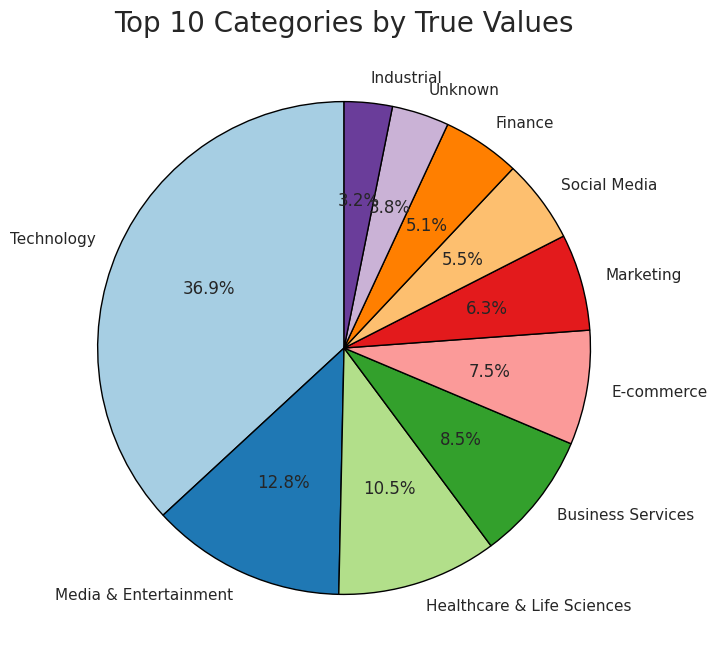

In [239]:
  plot_pie_chart_top_10(startups_train_cons, category_columns)

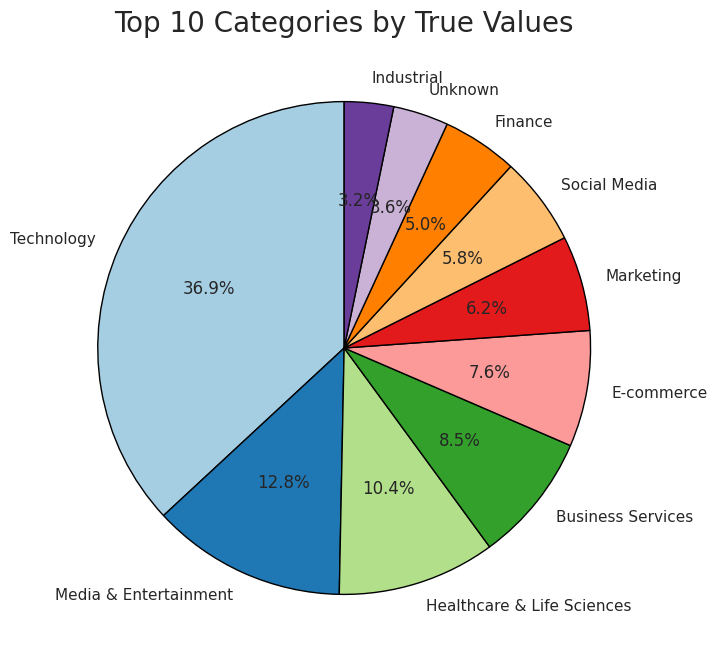

In [240]:
 plot_pie_chart_top_10(startups_test_cons, category_columns)

### Выводы

1. Массив **`geo_data_0`**, признаки:

    - `f0` минимальное значение -1.4, максимум 2.36, медиана 0.5, 95% значений менее 1.94.  Распределение симметричное относительно медианы. Есть 4 пика -1.0(2.9 тыс. скважин), 0.0(3.9 тыс скважин), 1.0(3.9 тыс. скважин), 1.7(3 тыс. скважин). Стандартное отклонение 0.87.

    - `f1` минимальное значение -7.08, максимум 7.85, медиана около 0, 95% значений менее 2.85.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом в нуле (7 тыс.  скважин). Стандартное отклонение 3.73.

    - `f2` минимальное значение -11.97, максимум 16.74, медиана 2.48, 95% значений менее 8.23.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом в медиане (6.5 тыс.  скважин). Стандартное отклонение 3.47.

    - `product` минимальное значение запасов 0, максимум 190 тыс. бареллей, медиана 94.92, 95% значений менее 166 тыс. бареллей.  Распределение симметричное относительно медианы. Имеется 6 пиков - 30 тыс. бареллей(2.4 тыс. скважин), 60 тыс. бареллей (2.9 тыс скважин), 80 тыс бареллей (2.9 тыс. скважин), 110 тыс. бареллей(2.9 тыс. скважин), 130 тыс. бареллей(2.9 тыс скважин), 155 тыс. бареллей(2.4 тыс. скважин). Стандартное отклонение 44.75.

    - **Диаграмма рассеяния (2-3d)** - явно видны два облака точек в координатах f0, f1, f2 закрученные в две спирали с рапределенным по ним значением уровня добычи (с небольшим его ростом с ростом значения f). Очень похоже, что f это трехмерные координаты расположения дна скважины в земле.

    - **Корелляции Пирсона** показали:

        1. Отсутствие высокой корелляции признаков с целевым признаком, только с увеличением f0 немного прирастает добыча

    - **Выводы по подготовке признаков:**

        1. Нужно масштабировать признаки

        2. Можно попробовать регуляризацию (Ridge или Lasso)

        3. В любом случае хорошего результата с применением только линейной регрессии ждать не приходится,  так как только один из трех признаков имееет пусть и слабую, но линейную взаимосвязь с целевым признаком.



2. Признаки массива **`geo_data_1`** имеют схожую картину как и у массива `geo_data_0`.

    - `f0` минимальное значение -31.6, максимум 29.4, медиана 1.14, 95% значений менее 15.  Распределение симметричное относительно медианы. Есть 2 пика -7 (5 тыс. скважин), 8(5 тыс скважин). Стандартное отклонение 8.96.

    - `f1` минимальное значение -26.36, максимум 18.73, медиана -4.81, 95% значений менее 3.67.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом медиане (7.5 тыс.  скважин). Стандартное отклонение 5.12.

    - `f2` минимальное значение -0.02, максимум 5.02, медиана 2.01, 95% значений менее 5.  Распределение имеет столбчатый вид со значениями группирующимися вокруг 0,1,2,3,4,5 (каждое примерно по 15 тыс. скважин). Стандартное отклонение 1.7.

    - `product` минимальное значение запасов 0, максимум 138 тыс. бареллей, медиана 68.82, 95% значений менее 138 тыс. бареллей.  Распределение имеет столбчатый вид со значениями группирующимися вокруг 0, 3.18, 26.95, 30.13, 53.91, 57.09, 80.86, 84.04, 111, 135 (каждое примерно по 8.3 тыс. скважин), шаг 3.18 кроме последних двух. Стандартное отклонение 1.7.

    - **Диаграмма рассеяния (2-3d)** - явно 6 наборов точек в координатах f0, f1, f2 ввиде поских блинов по оси f2 c единым значением уровня добычи (с его ростом с ростом значения f2). Очень похоже, что f это трехмерные координаты расположения дна скважины в земле.

    - **Корелляции Пирсона** показали:

        1.Высокую корелляции f2 с целевым признаком (0,99)

    - **Выводы по подготовке признаков:**

        1. Нужно масштабировать признаки

        2. Можно попробовать регуляризацию (Ridge или Lasso)

        3. Можно оставить только признак f2, остальные не будут никак влиять на результат.

 

3. Признаки массива **`geo_data_2`** имеют схожую картину как и у массива `geo_data_0`, `geo_data_1`.

    - `f0` минимальное значение -8.76, максимум 7.24, медиана 0.0009, 95% значений менее 2.85.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом медиане (7 тыс.  скважин). Стандартное отклонение 1.73.

    - `f1` минимальное значение -7.08, максимум 7.85, медиана 0.0097, 95% значений менее 2.85.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом медиане (7 тыс.  скважин). Стандартное отклонение 1.73. 

    - `f2` минимальное значение -11.97, максимум 16.74, медиана 2.48, 95% значений менее 8.23.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом медиане (6 тыс.  скважин). Стандартное отклонение 1.47.

    - `product` минимальное значение запасов 0, максимум 190 тыс. бареллей, медиана 94.92, 95% значений менее 166 тыс. бареллей.  Распределение симметричное относительно медианы. Имеется 6 пиков - 30 тыс. бареллей(2.4 тыс. скважин), 60 тыс. бареллей (2.9 тыс скважин), 80 тыс бареллей (2.9 тыс. скважин), 110 тыс. бареллей(2.9 тыс. скважин), 130 тыс. бареллей(2.9 тыс скважин), 155 тыс. бареллей(2.4 тыс. скважин). Стандартное отклонение 44.75.

    - **Диаграмма рассеяния (2-3d)** - эллипс вытянуты вдоль оси f0, в координатах f0, f1, f2 (с ростом уровня добычи с ростом значения f2). Очень похоже, что f это трехмерные координаты расположения дна скважины в земле.

    - **Корелляции Пирсона** показали:

        1.Отсутствие высокой корелляции признаков с целевым признаком, только с увеличением f2 немного прирастает добыча

    - **Выводы по подготовке признаков:**

        1. Нужно масштабировать признаки

        2. Можно попробовать регуляризацию (Ridge или Lasso)

        3. В любом случае хорошего результата с применением только линейной регрессии ждать не приходится,  так как только один из трех признаков имееет пусть и слабую, но линейную взаимосвязь с целевым признаком.

        

4. Скорее всего перед нами результаты разных принципов разведки месторождения:

    1. **0й регион** - скважины формируют две спирали, закрученные друг вокруг друга и измеряется фактическое содержание нефти на дне каждой скважины

    2. **1й регион** - в 6 горизонтах по всем скважинам измеряется некий константный уровень добычи с определенным шагом

    3. **2й регион** - скважины формируют эллипс, и измеряется фактическое содержание нефти на дне каждой скважины

    4. Можно предположить, что **f2 это глубина скважины**, измеряемя относительно какого-то горизонта или уровня моря. Причем положительные значения напревлены в сторону увеличения глубины.

## Обучение и проверка модели

### Обучаю модель для нулевого региона

In [ ]:
# Создание обучающей и тестовой выборки

X=geo_data_0.drop(columns=['product'])

y=geo_data_0['product']

In [ ]:
# Создаю список числовых колонок

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
# Создание пайплайна для числовых признаков

numeric_pipe = Pipeline([

    ('imputer_nan', SimpleImputer(missing_values=np.nan, strategy='mean')),

    ('scaler', StandardScaler())

])

In [ ]:
# Создание общего пайплайна для подготовки данных

data_preprocessor_num = ColumnTransformer([

    ('num', numeric_pipe, numeric_features)

], remainder='passthrough')

In [ ]:
# Определение параметров для поиска для разных моделей

param_distributions_reg = [

    {

        'preprocessor': [data_preprocessor_num],

        'model': [LinearRegression()],

        'model__fit_intercept': [True, False]

    }

]

In [ ]:
# Создание итогового пайплайна: подготовка данных и модель

pipe_final = Pipeline([

    ('preprocessor', data_preprocessor_num),

    ('model', LinearRegression())  # Это значение будет заменено

])

In [ ]:
# Создаю функцию для анализа остатков с помощью графиков

def res_graph(y_test, y_pred):

    residuals = y_test - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # График остатков

    axes[0].scatter(y_pred, residuals)

    axes[0].axhline(0, color='red', linestyle='--', linewidth=2)

    axes[0].set_xlabel('Прогнозные значения')

    axes[0].set_ylabel('Остатки')

    axes[0].set_title('Остатки и Прогнозные значения')

    

    # Гистограмма остатков

    axes[1].hist(residuals, bins=20, edgecolor='black')

    axes[1].set_xlabel('Остатки')

    axes[1].set_ylabel('Частота')

    axes[1].set_title('Гистограмма остатков')

    mean_residual = np.mean(residuals)

    axes[1].axvline(x=mean_residual, color='blue', linestyle='-', linewidth=2, label='Среднее значение остатков')

    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Нулевое значение')

    axes[1].legend()

    plt.tight_layout()

    plt.show()

In [ ]:
# Функция для поиска и обучения модели

def grid_search_r2(param_distributions, X, y):

    # Разделение на обучающую и валидационную выборки (75:25)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)



    grid_search = GridSearchCV(

        pipe_final, 

        param_distributions,  # Используем все комбинации

        scoring='r2',  # Оптимизация по R²

        cv=KFold(n_splits=5, shuffle=True, random_state=42),

        n_jobs=-1  # Использование всех доступных ядер процессора

    )



    # Обучение и поиск лучших гиперпараметров

    start_time = time.time()

    grid_search.fit(X_train, y_train)

    end_time = time.time()



    # Проверка времени выполнения

    elapsed_time = end_time - start_time

    print(f"Время выполнения: {elapsed_time} секунд.")



    # Применение лучших параметров для обучения и оценки модели

    best_pipe = grid_search.best_estimator_

    y_pred = best_pipe.predict(X_valid)

    

    # Рассчитываю метрики качества модели

    r2 = r2_score(y_valid, y_pred)

    mae = mean_absolute_error(y_valid, y_pred)

    mse = mean_squared_error(y_valid, y_pred)

    rmse = np.sqrt(mse)

    

    # Сохранение предсказаний и правильных ответов на валидационной выборке

    predictions_df = pd.DataFrame({

        'y_valid': y_valid,

        'y_pred': y_pred

    })

    

    

    # Вывод метрик

    avg_product_region = y_pred.mean()

    

    print(f"Средний запас предсказанного сырья: {avg_product_region}")



     # Анализ остатков

    res_graph(y_valid, y_pred)

    

    # Создание pandas DataFrame с названием модели и ее метриками на валидационной выборке

    best_model_name = type(best_pipe.named_steps['model']).__name__

    results_df = pd.DataFrame({

        'Model': [best_model_name],

        'R²': [r2],

        'MAE': [mae],

        'MSE': [mse],

        'RMSE': [rmse]

    })



    # Создание словаря с лучшими параметрами для модели

    best_params_dict = {

        best_model_name: [grid_search.best_params_, best_pipe]

    }



    return results_df, best_params_dict, predictions_df, avg_product_region

In [ ]:
# Обучаю линейную регрессию

results_0, best_params_0, predictions_0, avg_product_region_0 = grid_search_r2(param_distributions_reg, X, y)





# Вывод результата

print("Результаты:")

display(results_0)

print("Лучшие параметры:")

display(best_params_0)

***Выводы:***

1. Диаграмма рассеяния остатков имеет форму ромба - модель недостаточно хорошо описывает нелинейные зависимости между признаками и целевым признаком.. 

2. Остатки распределены симметрично и нормально. Смещения почти нет. Это хорошо.

3. Модель имеет низкую предсказательную способность - объясняет только 28% процентов целевого признака.

### Обучаю модель для первого региона

In [ ]:
# Создание обучающей и тестовой выборки

X=geo_data_1.drop(columns=['product'])

y=geo_data_1['product']

In [ ]:
# Обучаю линейную регрессию

results_1, best_params_1, predictions_1, avg_product_region_1 = grid_search_r2(param_distributions_reg, X, y)





# Вывод результата

print("Результаты:")

display(results_1)

print("Лучшие параметры:")

display(best_params_1)

***Выводы:***

1. Диаграмма рассеяния остатков имеет форму повторяющихся линий - это логично, модель недостаточно хорошо описывает нелинейные зависимости между признаками и целевым признаком.. 

2. Остатки распределены симметрично и нормально. Смещения почти нет. Это хорошо.

3. Модель имеет высокую предсказательную способность - объясняет 100% процентов целевого признака.

4. Явно модель переобучена из-за сильно корелляции признака f0 с product.

### Обучаю модель для второго региона

In [ ]:
# Создание обучающей и тестовой выборки

X=geo_data_2.drop(columns=['product'])

y=geo_data_2['product']

In [ ]:
# Обучаю линейную регрессию

results_2, best_params_2, predictions_2, avg_product_region_2 = grid_search_r2(param_distributions_reg, X, y)





# Вывод результата

print("Результаты:")

display(results_2)

print("Лучшие параметры:")

display(best_params_2)

### Выводы

1. Хороших результатов с помощью линейной регрессии получить не удалось - из-за нелинейной кореляции признаков нулевого и первого региона и слишком сильной кореляции с целевым признаком одного признака и отсутствием ее для остальных признаков в данных региона №1.

2. Лучшие результаты:

**Регион 0**

In [ ]:
# Вывод результата



print(f"Средний запас предсказанного сырья: {avg_product_region_0}")

print("Результаты:")

display(results_0)

print("Лучшие параметры:")

display(best_params_0)

**Регион 1**

In [ ]:
# Вывод результата

print(f"Средний запас предсказанного сырья: {avg_product_region_1}")

print("Результаты:")

display(results_1)

print("Лучшие параметры:")

display(best_params_1)

**Регион 2**

In [ ]:
# Вывод результата

print(f"Средний запас предсказанного сырья: {avg_product_region_2}")

print("Результаты:")

display(results_2)

print("Лучшие параметры:")

display(best_params_2)

## Общие выводы

1. Проанализированы массивы из трех регионов (`geo_data_0`, `geo_data_1`, `geo_data_2`), которые содержат данные для 100 тысяч скважин каждый, 4 колонки.

2. В массивах явно есть нелинеиные зависимости между признаками и по отношению к целевому признаку. Тулько у массива `geo_data_1` есть высокая корелляция признака f2 с целевым признаком (0,99).

3. Скорее всего перед нами результаты разных принципов разведки месторождения:

   - 0й регион - скважины формируют две спирали, закрученные друг вокруг друга и измеряется фактическое содержание нефти на дне каждой скважины

   - 1й регион - в 6 горизонтах по всем скважинам измеряется некий константный уровень добычи с определенным шагом

   - 2й регион - скважины формируют эллипс, и измеряется фактическое содержание нефти на дне каждой скважины

   - Можно предположить, что f2 это глубина скважины, измеряемя относительно какого-то горизонта или уровня моря. Причем положительные значения напревлены в сторону увеличения глубины.

4. Хороших результатов с помощью линейной регрессии получить не удалось - из-за нелинейной кореляции признаков нулевого и первого региона и слишком сильной кореляции с целевым признаком одного признака и отсутствием ее для остальных признаков в данных региона №1.

5. Достаточный объём сырья для безубыточной разработки одной скважины: 111.11 тыс. баррелей. Средний запас сырья у всех регионов ниже объема, необходимого для безубыточной разработки одной скважины.

6. Рекомендуется выбрать регион для разработки:

In [ ]:
best_region

7. Доверительный интервал указывает, что в 95% случаев средняя прибыль для региона 1 будет находиться в диапазоне от 67,299,569.59 до 821,082,242.58 рублей. Это означает, что в худшем случае прибыль составит чуть более 67 млн рублей, а в лучшем — чуть более 821 млн рублей. Это достаточно широкий интервал и связано это в первую очередь с нелинейными взаимосвязями в данных и органичением в выборе только линейной регрессии для модели прогноза уровня добычи.